In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [19]:
file_types = ["cuda", "omp"]
def get_file_type(types, fname):
    for t in types:
        if t in fname:
            return t
    return None

def read_data(dir_name, file_types):
    if dir_name[-1] != "/":
        dir_name += "/"
    files = os.listdir(dir_name)

    result = {x:[] for x in file_types}
    for file in files:
        t = get_file_type(file_types, file)
        df = pd.read_csv(dir_name + file, sep="\s*\|\s*", engine='python')
        result[t].append(df)


    for t in file_types:
        result[t] = pd.concat(result[t])
        result[t].reset_index(drop=True, inplace=True)
        result[t].rename(columns={"Time (ms)": "time"}, inplace=True)

    return result

In [20]:
res = read_data("./bemchmark_results/", file_types)

In [21]:
df.columns

Index(['N', 'streams', 'kernel', 'memory', 'time', 'GFLOPS'], dtype='object')

In [35]:
ker_types = df.kernel.unique()
mem_types = df.memory.unique()
streams_arr = df.streams.unique()
N_arr = df.N.unique()

ker2i = {ker: i for i, ker in enumerate(ker_types)}
mem2i = {mem: i for i, mem in enumerate(mem_types)}
stream2i = {stream: i for i, stream in enumerate(streams_arr)}

print(ker_types)
print(mem_types)
print(streams_arr)

['Simple' 'Shared' 'Shared_2' 'Shared_3' 'cuBLAS']
['Simple' 'Pinned' 'Unified']
[1 2 4 8]


## Определения
### Типы памяти:
    Simple - обычные указатели
    Pinned - cuda pinned memory
    Unified - cuda managed memory
### Типы ядер:
    Simple - базовая имплементация перемножения матриц
    Shared - перемножение с подгрузкой в разделяемую память
    Shared_2 - оптимизация банков памяти за счёт сдвига разделяемой памяти
    Shared_3 - оптимизация банков памяти за счёт транспонирования разделяемой памяти

### Количество потоков
    streams - количество куда потоков, на которые разделялась задача

# CUDA

In [23]:
df = res["cuda"]

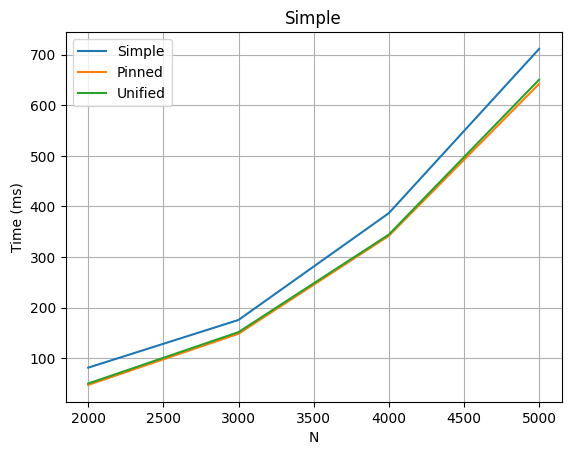

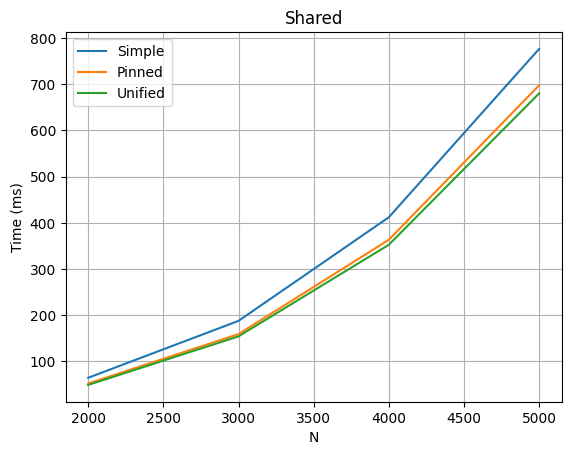

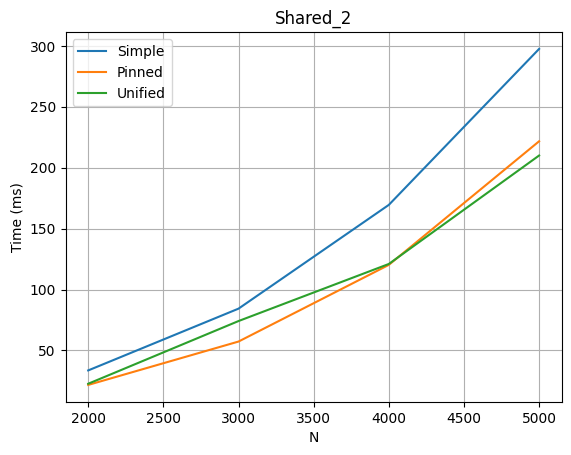

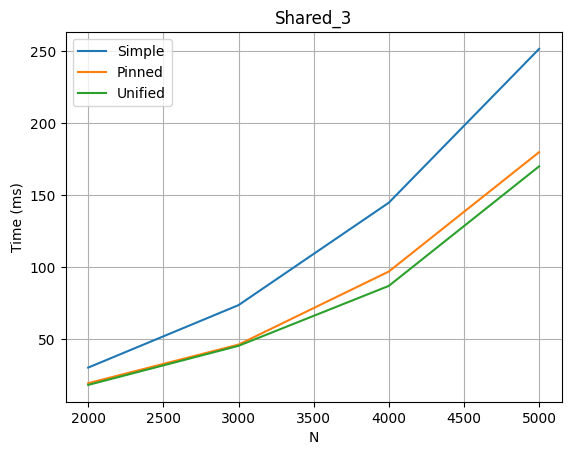

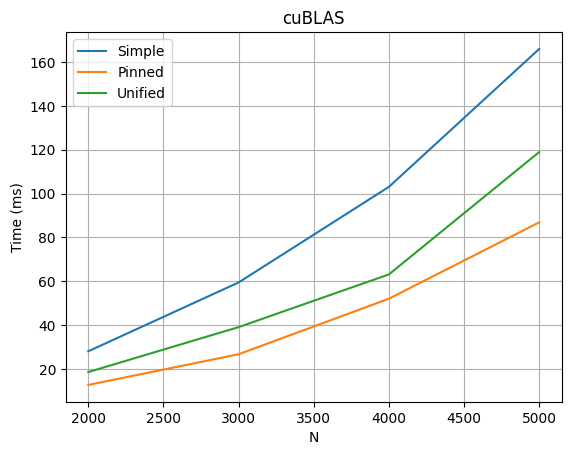

In [24]:
for kernel in ker_types:
    df_ker = df[(df.kernel == kernel) & (df.streams == 1)].copy()

    df_ker.sort_values(by=["memory", "N"], inplace=True)
    plt.figure()
    for mem in mem_types:
        df_mem = df_ker[df_ker.memory == mem]
        plt.plot(df_mem.N, df_mem.time, label=mem)
    
    plt.legend(loc="best")
    plt.title(kernel)
    plt.xlabel("N")
    plt.ylabel("Time (ms)")
    plt.grid(True)
    plt.show()

Использование unified и pinned память значительно ускоряет передачу данных, оба метода показывают примерно одинаковые результаты.

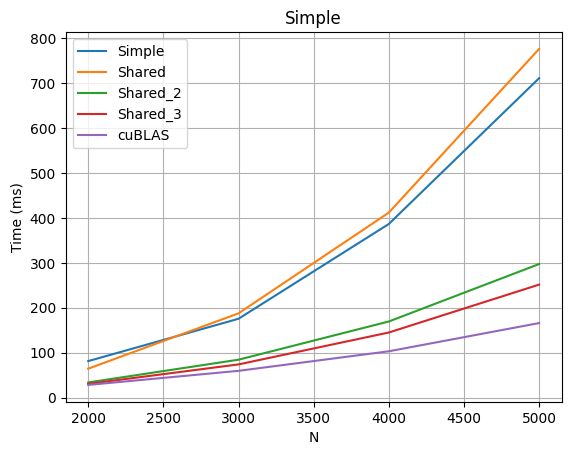

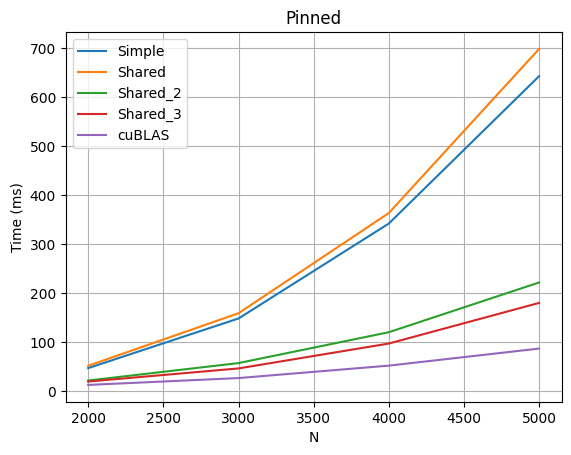

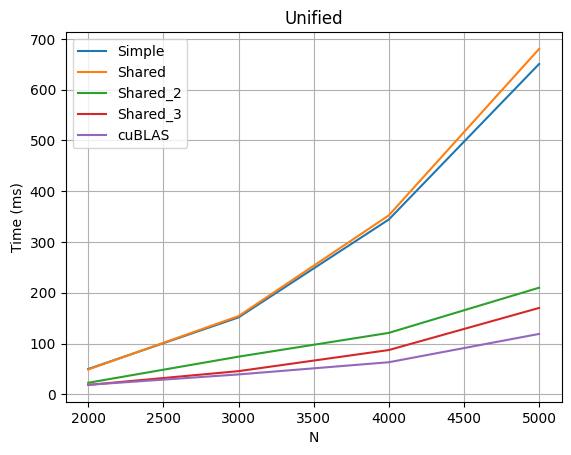

In [25]:
for mem in mem_types:
    df_mem = df[(df.memory == mem) & (df.streams == 1)].copy()

    df_mem.sort_values(by=["kernel", "N"], inplace=True)
    plt.figure()
    for kernel in ker_types:
        df_ker = df_mem[df_mem.kernel == kernel]
        plt.plot(df_ker.N, df_ker.time, label=kernel)
    
    plt.legend(loc="best")
    plt.title(mem)
    plt.xlabel("N")
    plt.ylabel("Time (ms)")
    plt.grid(True)
    plt.show()

Shared_3 показывает лучший результат из реализованных функций. 
И Shared_2, и Shared_3 работают значительно быстрее чем Shared. Однако сдвиг памяти по банкам в Shared_2 хоть и уменьшает количество конфликтов банков, но не убирает их полностью, в отличие от Shared_3, где конфликты банков невозможны.

In [26]:
import itertools

In [27]:
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle

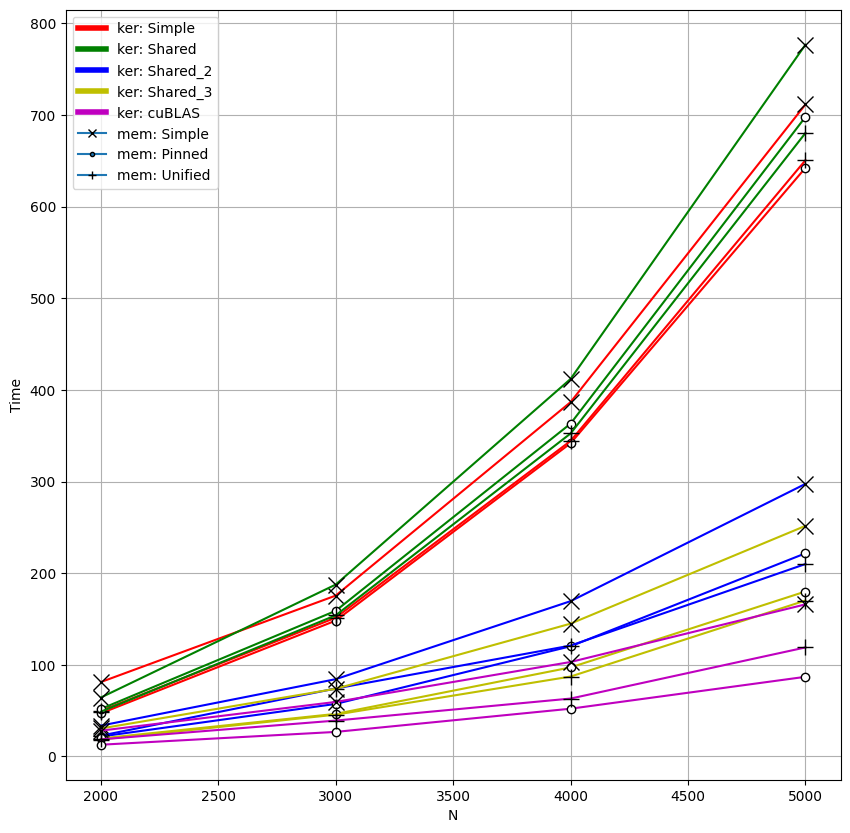

In [28]:
def foo():
    df_1 = df[df.streams == 1].copy()
    df_1.sort_values(by=["N"], inplace=True)
    plt.figure(figsize=(10, 10))
    colors = ["r", "g", "b", "y", "m", "c"]
    colors = colors[:len(ker_types)]
    markers = ["x", ".", "+", 7, 8, "s"]
    markers = markers[:len(mem_types)]

    custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in range(len(colors))]
    custom_markers = [Line2D([0], [0], marker=x, markeredgecolor="black") for x in markers]

    for ker, mem in itertools.product(ker_types, mem_types):
        df_cur = df_1[(df_1.kernel == ker) & (df_1.memory == mem)]
        plt.plot(df_cur.N, df_cur.time, linestyle="-", marker=markers[mem2i[mem]], mec="black",
                 mfc="1", markersize=12, color=colors[ker2i[ker]], alpha=1, label=f"k:{ker}, m:{mem}")

    plt.xlabel("N")
    plt.ylabel("Time")
    plt.grid(True)
    plt.legend(custom_lines + custom_markers, ("ker: " + ker_types).tolist() + ("mem: " + mem_types).tolist())
    plt.show()

foo()

Не считая cuBLAS, при работе с одним потоком, показывает вариант \
ядро: Shared_3, память: Unified 

## Streams
Для удобства влияние количества потоков будет рассматриваться только для ядер: Shared_3 и cuBLAS

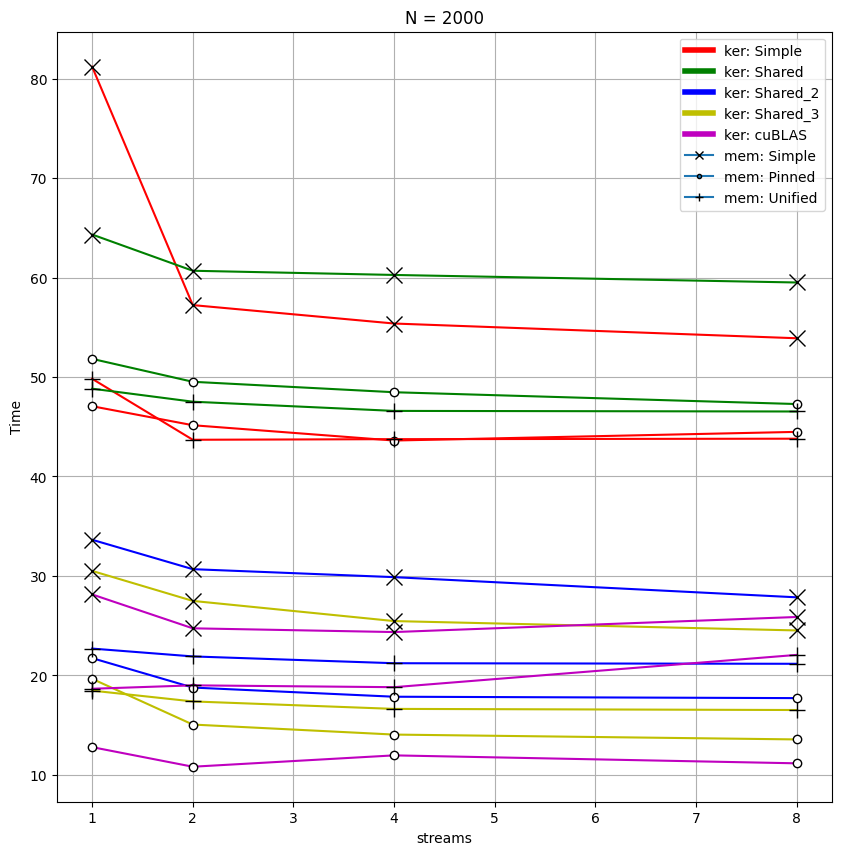

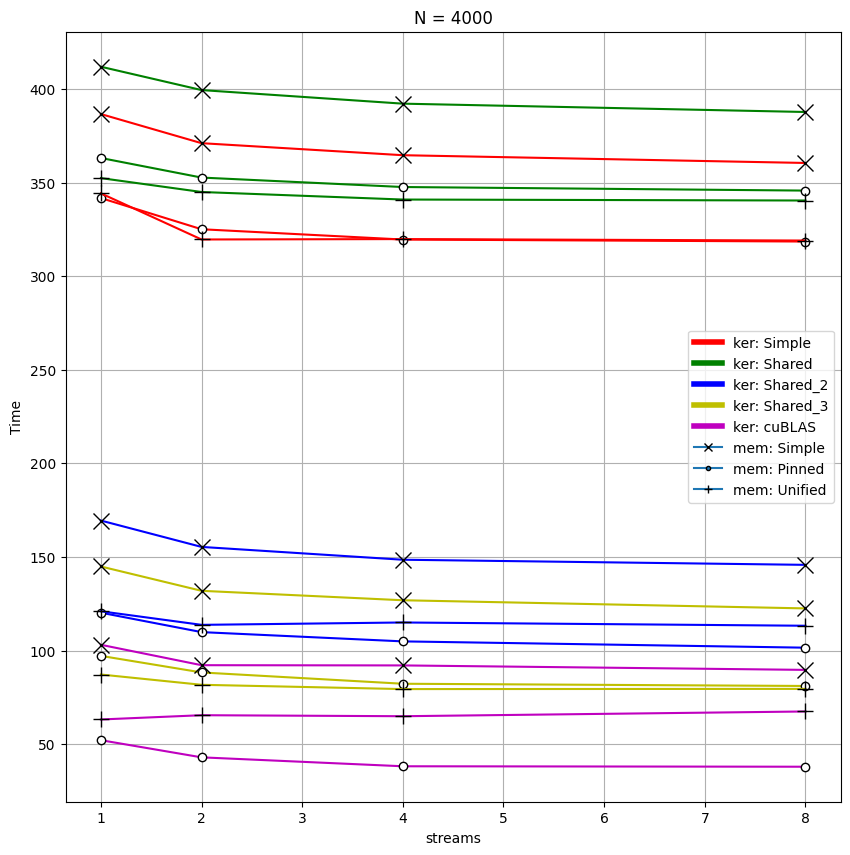

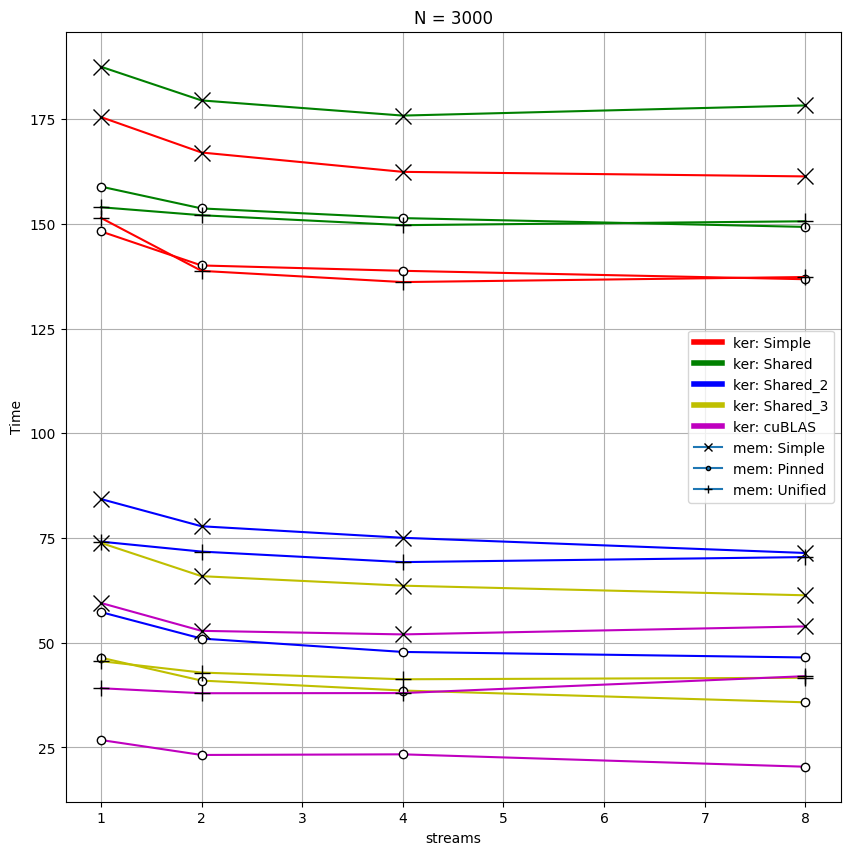

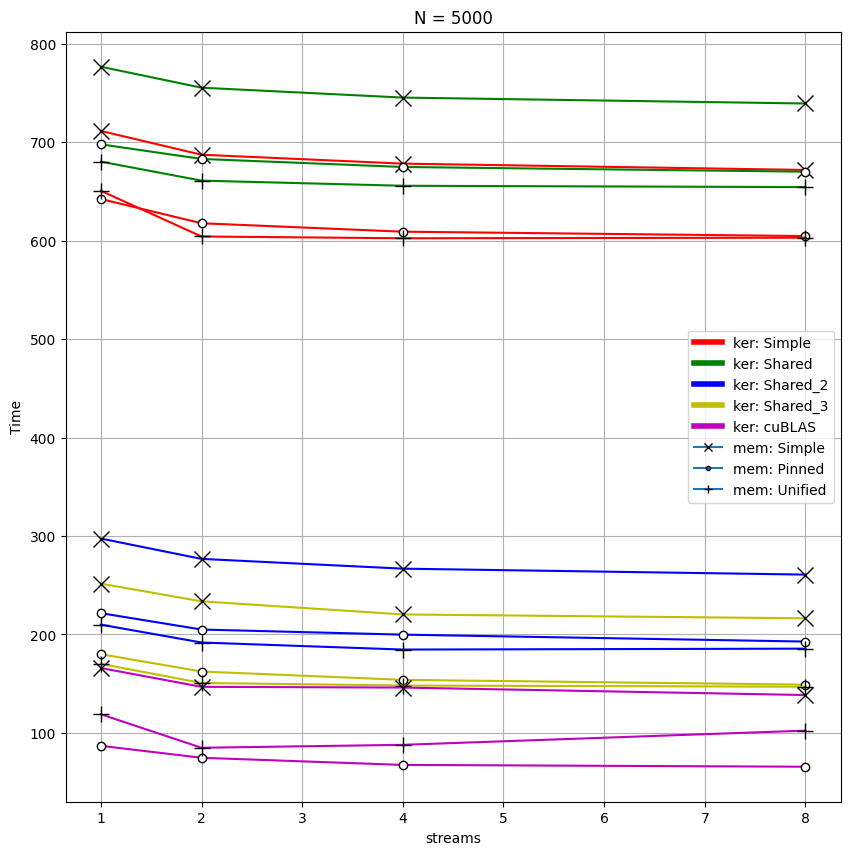

In [38]:
def foo():
    for n in N_arr:
        df_1 = df[df.N == n].copy()
        df_1.sort_values(by=["streams"], inplace=True)
        plt.figure(figsize=(10, 10))
        plt.title(f"N = {n}")
        colors = ["r", "g", "b", "y", "m", "c"]
        colors = colors[:len(ker_types)]
        markers = ["x", ".", "+", 7, 8, "s"]
        markers = markers[:len(mem_types)]

        custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in range(len(colors))]
        custom_markers = [Line2D([0], [0], marker=x, markeredgecolor="black") for x in markers]

        for ker, mem in itertools.product(ker_types, mem_types):
            df_cur = df_1[(df_1.kernel == ker) & (df_1.memory == mem)]
            plt.plot(df_cur.streams, df_cur.time, linestyle="-", marker=markers[mem2i[mem]], mec="black",
                    mfc="1", markersize=12, color=colors[ker2i[ker]], alpha=1, label=f"k:{ker}, m:{mem}")

        plt.xlabel("streams")
        plt.ylabel("Time")
        plt.grid(True)
        plt.legend(custom_lines + custom_markers, ("ker: " + ker_types).tolist() + ("mem: " + mem_types).tolist())
        plt.show()

foo()

Увеличение количества потоков даёт прирост в скорости, для большинства алгоритмов 2-х потоков достаточно, и следующее увеличение их числа не даёт большой разницы.

# Лучший вариант

In [29]:
# best performing combination for each matrix size
df.iloc[df.groupby(by="N").idxmin().time]

,N,streams,kernel,memory,time,GFLOPS
28,2000,2,cuBLAS,Pinned,10.822187,1478.444179
178,3000,8,cuBLAS,Pinned,20.392773,2647.996958
118,4000,8,cuBLAS,Pinned,37.918755,3375.638294
238,5000,8,cuBLAS,Pinned,65.685867,3805.993743


In [30]:
# best performing combination for each matrix size without cuBLAS
df.iloc[df[df.kernel != "cuBLAS"].groupby(by="N").idxmin().time]

,N,streams,kernel,memory,time,GFLOPS
55,2000,8,Shared_3,Pinned,13.566030,1179.416567
175,3000,8,Shared_3,Pinned,35.774437,1509.457719
101,4000,4,Shared_3,Unified,79.401260,1612.065091
236,5000,8,Shared_3,Unified,146.950790,1701.249781


# OMP

In [31]:
df_omp = res["omp"]

In [32]:
df_omp

,N,time,GFLOPS
0,4000,6223.870277,20.57
1,3000,3688.225651,14.64
2,2000,1631.576276,9.81
3,5000,12778.176785,19.56


In [33]:
df_omp.sort_values(by="N", inplace=True)

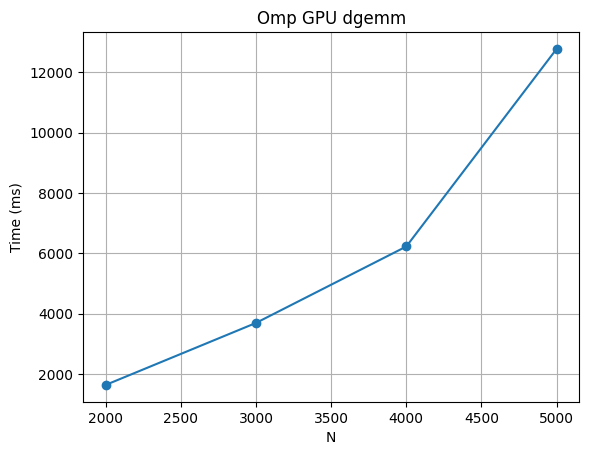

In [34]:
plt.plot(df_omp.N, df_omp.time, '-o')
plt.xlabel('N')
plt.title('Omp GPU dgemm')
plt.ylabel("Time (ms)")
plt.grid()
plt.show()


Базовая реализация на openmp работает в 20 раз медленней чем базовая реализация на cuda.